# 2 Sample Tests Power over Increasing Dimension

Please use ``hyppo <= 0.1.3`` and the ``random-forest`` branch.

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power_2samp import power
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
# from hyppo.ksample import Hotelling
from hyppo.tools import *

sys.path.append(os.path.realpath('..'))

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from hyppo.random_forest.base import RandomForestTest
from hyppo.random_forest._utils import _CheckInputs, sim_matrix
from hyppo._utils import perm_test, euclidean


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(RandomForestTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="classifier", n_estimators=500, **kwargs):
        self.first_time = True
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("Forest must be classifier or regressor")
        RandomForestTest.__init__(self)

    def _statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        if self.first_time:
            y = y.reshape(-1)
            self.clf.fit(x, y)
            self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        y = y.reshape(-1, 1)
        disty = euclidean(y)
        stat = Dcorr(compute_distance=None)._statistic(distx, disty)
        self.stat = stat

        return stat

    def test(self, x, y, reps=1000, workers=1):
        r"""
        Calculates the random forest based Dcorr test statistic and p-value.
        """
        check_input = _CheckInputs(x, y, reps=reps)
        x, y = check_input()

        stat, pvalue, _ = perm_test(self._statistic, x, y, reps=reps, workers=workers, is_distsim=False)
        self.stat = stat
        self.pvalue = pvalue

        return stat, pvalue

In [3]:
MAX_DIMENSION = 10
STEP_SIZE = 1
DIMENSIONS = range(1, MAX_DIMENSION + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
#     Hotelling,
    KMERF,
    MGC,
    Dcorr,
    Hsic,
    HHG,
    CCA,
    RV,
]

In [4]:
RENAME_TESTS = {
    "Dcorr": "Energy",
    "Hsic": "MMD"
}

def estimate_power(sim, test):
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power_2samp_dimension(test, trans_2samp, sim, p=dim) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    if test.__name__ in ["Dcorr", "Hsic"]:
        np.savetxt('../kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, RENAME_TESTS[test.__name__]),
               est_power, delimiter=',')
    else:
        np.savetxt('../kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                   est_power, delimiter=',')
    
    return est_power

In [5]:
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
# )

In [6]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [7]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Two-Sample Testing", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                hsic_power = np.genfromtxt('../kmerf/2samp_vs_dimension/{}_Hsic.csv'.format(sim), delimiter=',')
                
                if test_name == "Dcorr":
                    test_name = "Energy"
                elif test_name == "Hsic":
                    test_name = "MMD"

                if test_name == "MGC":
                    col.plot(DIMENSIONS[2:], (power - hsic_power)[2:], color="#e41a1c", label=test_name, lw=4)
                elif test_name == "KMERF":
                    col.plot(DIMENSIONS[2:], (power - hsic_power)[2:], color="#e41a1c", label=test_name, lw=4, linestyle='dashed')
                else:
                    col.plot(DIMENSIONS[2:], (power - hsic_power)[2:], label=test_name, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([DIMENSIONS[2], DIMENSIONS[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Dimension', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to MMD', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../kmerf/figs/2samp_power_dimension.pdf', transparent=True, bbox_inches='tight')

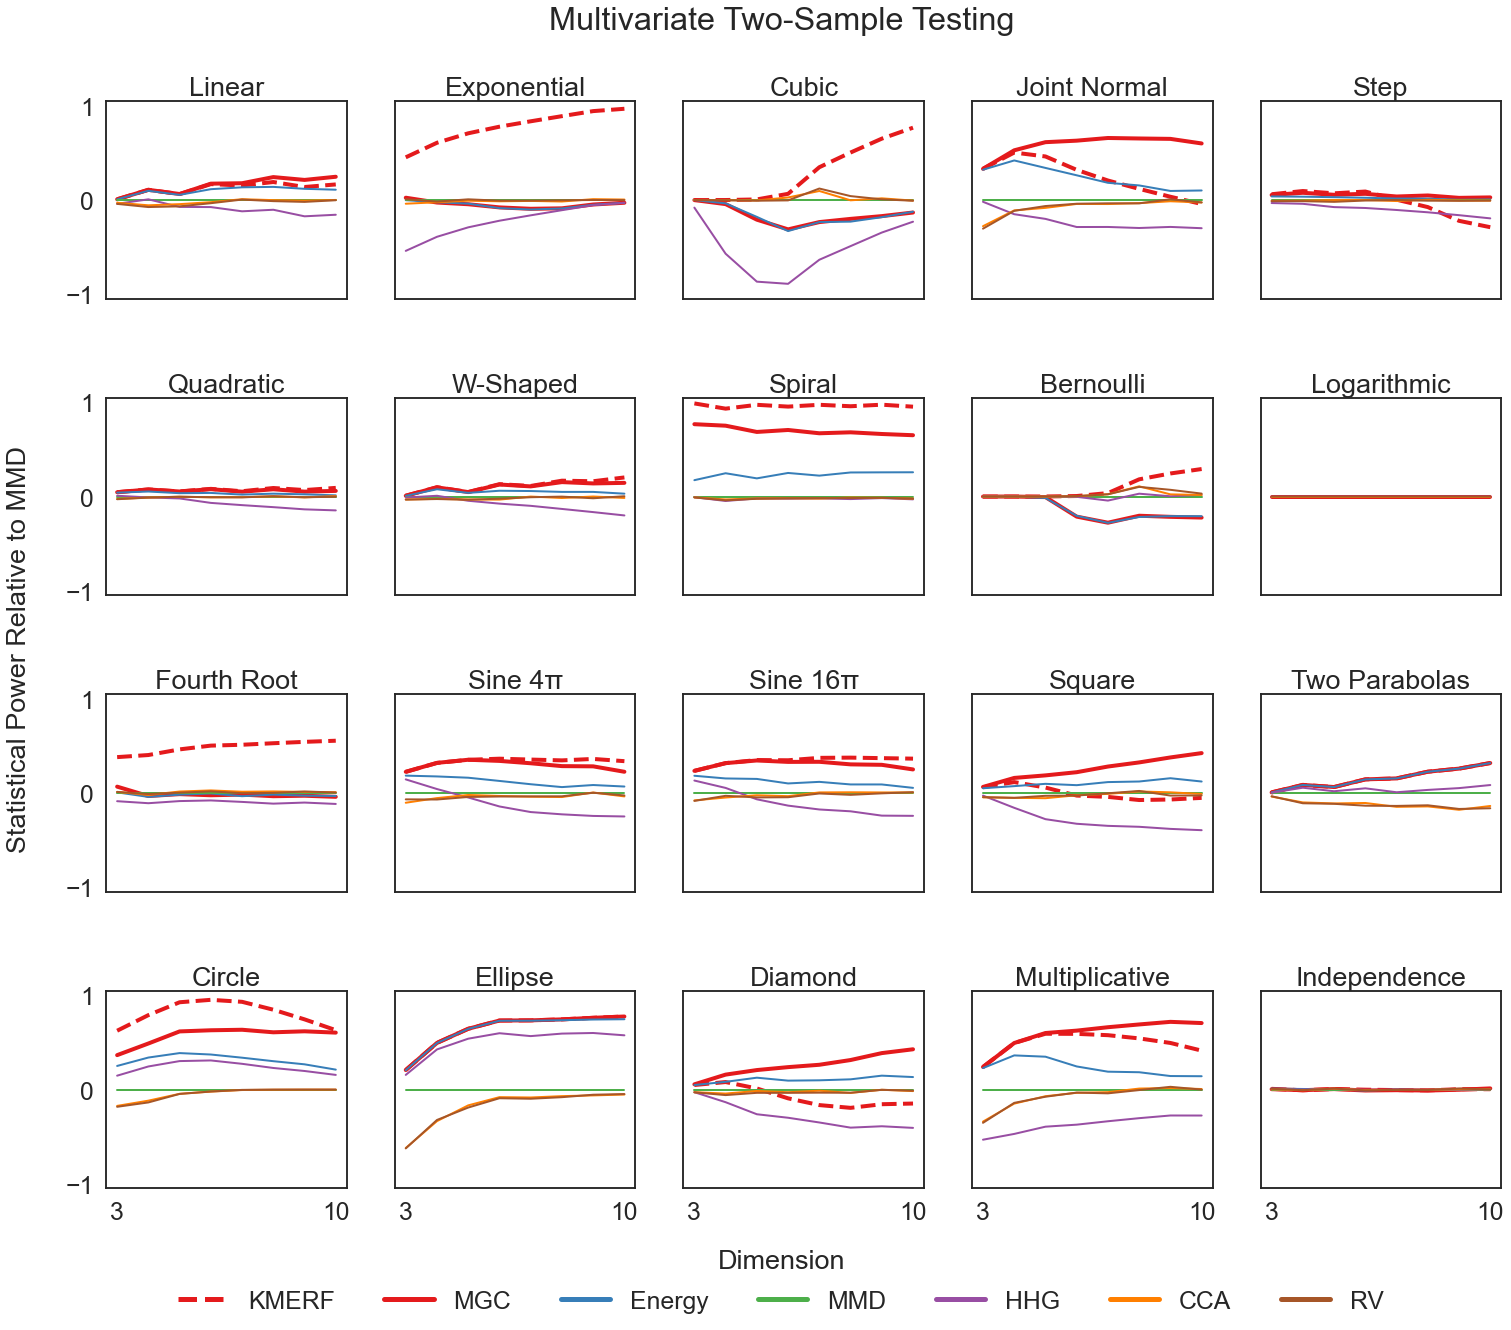

In [8]:
plot_power()